# Data Preprocessing

>1. filter out non-US countries 
>2. fill 'NaN' Province/State values with Country/Region values
>3. (optionally) apply log transformation to target values

In [27]:
# load and clean data
import pandas as pd

train_all = pd.read_csv("/root/data/train.csv")

def preprocess(
    frame: pd.DataFrame,
    log_transform: bool = False
):
    
    # set index
    new_frame = frame.set_index('Date')

    # filter countries
    new_frame = new_frame[new_frame['Country/Region'] == 'US']
        
    # convert target values to log scale
    if log_transform:
        new_frame[['ConfirmedCases', 'Fatalities']] = np.log1p(
            new_frame[['ConfirmedCases', 'Fatalities']].values
    )
    
    return new_frame

def split(
    df: pd.DataFrame, 
    date: str = '2020-03-20'
):
    train = df.loc[df.index < date] 
    test = df.loc[df.index >= date]
    return train, test

train_all = preprocess(train_all)
_, train_all = split(train_all, date = '2020-03-01')
train, test = split(train_all)


# Data Exploration

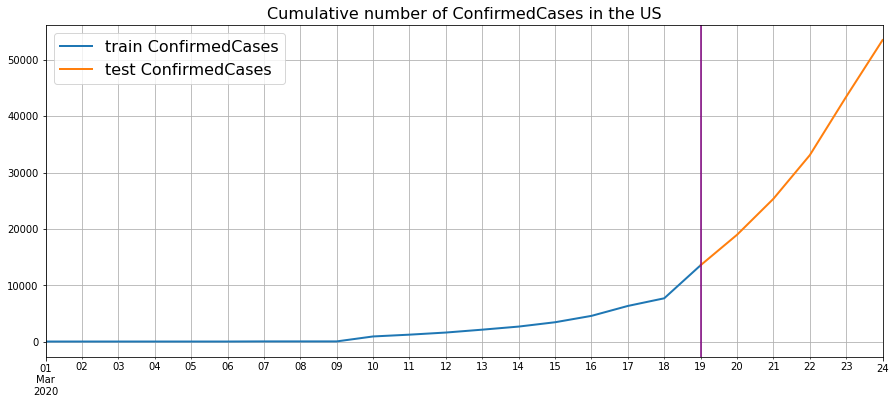

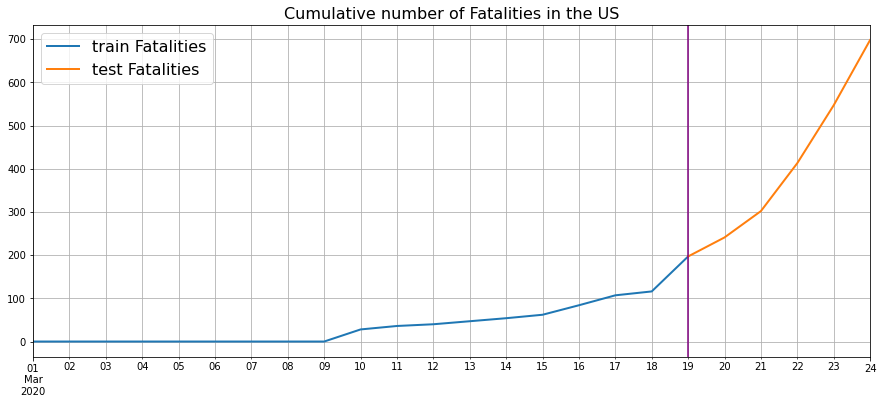

In [28]:
# plot confirmed cases and fatalities in train
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset

cum_train = train.groupby('Date').sum()
cum_test = test.groupby('Date').sum()

def plot_observations(
    target: str = 'ConfirmedCases'
):
    fig = plt.figure(figsize=(15, 6.1), facecolor="white",  edgecolor='k')

    train_ds = ListDataset(
        [{"start": cum_train.index[0], "target": cum_train[target].values}],
        freq = "D",
    )
    test_ds = ListDataset(
        [{"start": cum_test.index[0], "target": cum_test[target].values}],
        freq = "D",
    )
    
    for tr, te in zip(train_ds, test_ds):
        tr = to_pandas(tr)
        te = to_pandas(te)
        tr.plot(linewidth=2, label = f'train {target}')
        tr[-1:].append(te).plot(linewidth=2, label = f'test {target}')
    
    plt.axvline(cum_train.index[-1], color='purple') # end of train dataset
    plt.title(f'Cumulative number of {target} in the US', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(which="both")
    plt.show()
    
plot_observations('ConfirmedCases')
plot_observations('Fatalities')

# Data Augmentation

>1. Categorical feature for 'Province/State'
2. Categorical feature for 'Country/Region'


In [29]:
from sklearn.preprocessing import OrdinalEncoder

expend = pd.read_csv(
    '/root/data/state_level_data/healthcare_expenditures_2014.csv', 
    header=2, 
    skipfooter=16,
    engine='python'
)
expend['Total Health Spending'] = expend['Total Health Spending'].str.lstrip('$').astype(int)

expend_per_c = pd.read_csv(
    '/root/data/state_level_data/healthcare_expenditures_per_capita_2014.csv', 
    header=2, 
    skipfooter=34,
    engine='python'
)
expend_per_c = expend_per_c.applymap(lambda x: x.lstrip('$'))
expend_per_c.loc[:, expend_per_c.columns != 'Location'] = expend_per_c.loc[:, expend_per_c.columns != 'Location'].astype(int)

private = pd.read_csv(
    '/root/data/state_level_data/private_health_spending_2014.csv', 
    header=2, 
    skipfooter=13,
    engine='python'
)
private['Total Private Health Insurance Spending'] = private['Total Private Health Insurance Spending'].str.lstrip('$').astype(int)

private_per_c = pd.read_csv(
    '/root/data/state_level_data/private_spending_per_capita_2014.csv', 
    header=2, 
    skipfooter=16,
    engine='python'
)
private_per_c['Per Capita Private Health Insurance Spending'] = private_per_c['Per Capita Private Health Insurance Spending'].str.lstrip('$').astype(int)

hospital = pd.read_csv(
    '/root/data/state_level_data/hospital_expenses_2018.csv', 
    header = 2, 
    skipfooter=14,
    engine='python'
)
hospital.loc[hospital['State/Local Government Hospitals'].isna(), 'State/Local Government Hospitals'] = \
    hospital.loc[~hospital['State/Local Government Hospitals'].isna(), 'State/Local Government Hospitals'].mode()[0]    
hospital.loc[hospital['For-Profit Hospitals'].isna(), 'For-Profit Hospitals'] = \
    hospital.loc[~hospital['For-Profit Hospitals'].isna(), 'For-Profit Hospitals'].mode()[0]    
hospital = hospital.applymap(lambda x: x.lstrip('$'))
hospital.loc[:, hospital.columns != 'Location'] = hospital.loc[:, hospital.columns != 'Location'].astype(int)

def join(
    df: pd.DataFrame,
    health_df: pd.DataFrame
):
    
    # join, delete merge columns
    new_df = df.reset_index().merge(
        health_df,
        left_on = 'Province/State',
        right_on = 'Location',
        how = 'inner'
    ).set_index('Date')
    new_df = new_df.drop(columns=['Location'])
    
    assert not new_df.isnull().sum().any()
    
    return new_df

def encode(
    df: pd.DataFrame
):
    """ encode 'Province/State' and 'Country/Region' categorical variables as numerical ordinals"""
    
    enc = OrdinalEncoder()
    df['Province/State'] = enc.fit_transform(df['Province/State'].values.reshape(-1,1))
    return df, enc

join_df = join(train_all, expend)
join_df = join(join_df, expend_per_c)
join_df = join(join_df, private)
join_df = join(join_df, private_per_c)
join_df = join(join_df, hospital)

all_df, enc = encode(join_df)
train_df, test_df = split(all_df)
_, val_df = split(all_df, date = '2020-03-15')


In [30]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import typing

not_real_cols = ['Id', 'Province/State', 'Country/Region', 'Lat', 'Long', 'ConfirmedCases', 'Fatalities']
REAL_VARS = [col for col in all_df.columns if col not in not_real_cols]

def build_dataset(
    frame: pd.DataFrame,
    target: str = 'Fatalities',
    cat_vars: typing.List[str] = ['Province/State'],
    real_vars: typing.List[str] = REAL_VARS
):
    return ListDataset(
        [
            {
                FieldName.START: df.index[0], 
                FieldName.TARGET: df[target].values,
                FieldName.FEAT_STATIC_CAT: df[cat_vars].values[0],
                FieldName.FEAT_STATIC_REAL: df[real_vars].values[0]
            }
            for g, df in frame.groupby(by=['Province/State'])
        ],
        freq = "D",
    )

training_data_fatalities = build_dataset(train_df)
training_data_cases = build_dataset(train_df, target = 'ConfirmedCases')
training_data_fatalities_all = build_dataset(all_df)
training_data_cases_all = build_dataset(all_df, target = 'ConfirmedCases')
val_data_fatalities = build_dataset(val_df)
val_data_cases = build_dataset(val_df, target = 'ConfirmedCases')

# Fit DeepAR Model Estimates

The DeepAR model was proposed by David Salinas, Valentin Flunkert, and Jan Gasthaus in "DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks" (https://arxiv.org/abs/1704.04110). The approach trains an autoregressive RNN to produces time-variant parameters of a specified distribution on a large collection of related time series. The learned distribution can then be used to produce probabilistic forecasts. Here we use the authors' *GluonTS* implementation (https://gluon-ts.mxnet.io/index.html).

We believe the probabilistic nature of the DeepAR forecasts is a feature that differentiates our approach from others we have seen so far. Specifically, the ability to provide both confidence intervals and point estimates allows one to better understand the range of possible trajectories, from the worst-case scenario, to the best-case scenario, to the expected scenario. 

*TODO:*
> 1. Experiment with adding learned Box Cox transformation before learning Negative Binomial paramaters?

In [ ]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.distribution import NegativeBinomialOutput
import mxnet as mx
import numpy as np

# set random seeds for reproducibility
mx.random.seed(42)
np.random.seed(42)

def fit(
    training_data: ListDataset,
    validation_data: ListDataset = None,
    use_real_vars: bool = True,
    pred_length: int = 5,
    epochs: int = 20,
    weight_decay: float = 5e-5
):
    estimator = DeepAREstimator(
        freq="D", 
        prediction_length=pred_length,
        use_feat_static_real = use_real_vars,
        use_feat_static_cat = True,
        cardinality = [train['Province/State'].nunique()],
        distr_output=NegativeBinomialOutput(),
        trainer=Trainer(
            epochs=epochs,
            learning_rate=0.001, 
            batch_size=64,
            weight_decay=weight_decay
        ),
    )
    _, trained_net, predictor = estimator.train_model(
        training_data = training_data, 
        validation_data = validation_data
    )
    
    return predictor, trained_net

#predictor_fatalities, net = fit(training_data_fatalities, val_data_fatalities, use_real_vars = False)
#predictor_fatalities_aug, aug_net = fit(training_data_fatalities, val_data_fatalities)
#predictor_cases = fit(training_data_cases, val_data_cases, epochs=20)
predictor_fatalities_all = fit(training_data_fatalities_all, pred_length=7, use_real_vars = False)
#predictor_cases_all = fit(training_data_cases_all, pred_length=7)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

# Plot predictions from fit model parameters

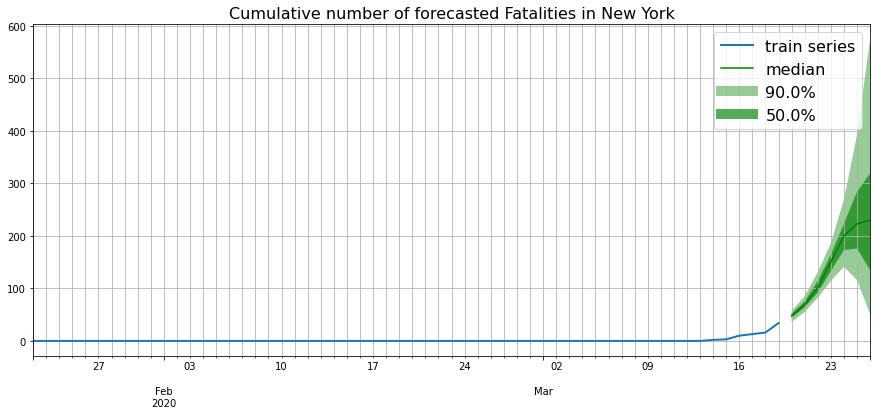

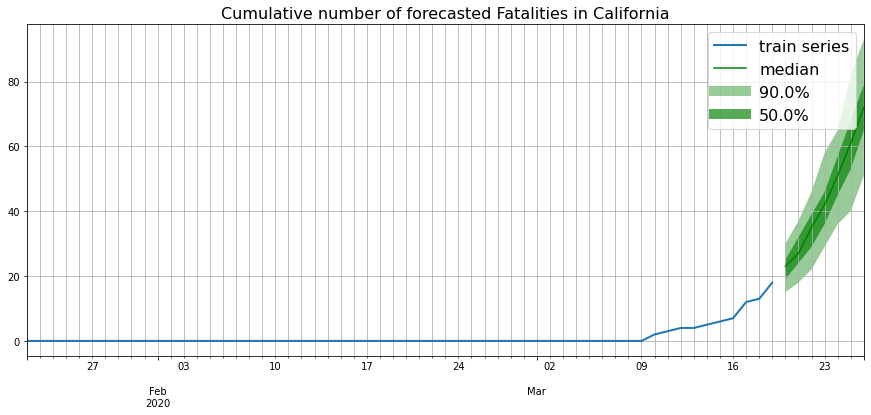

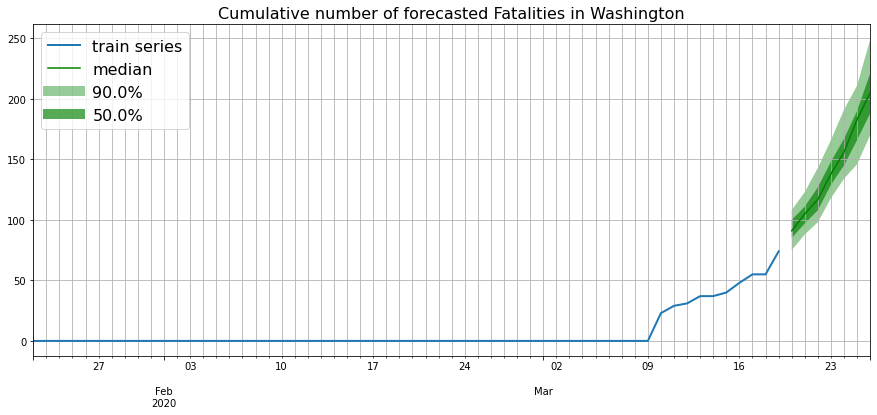

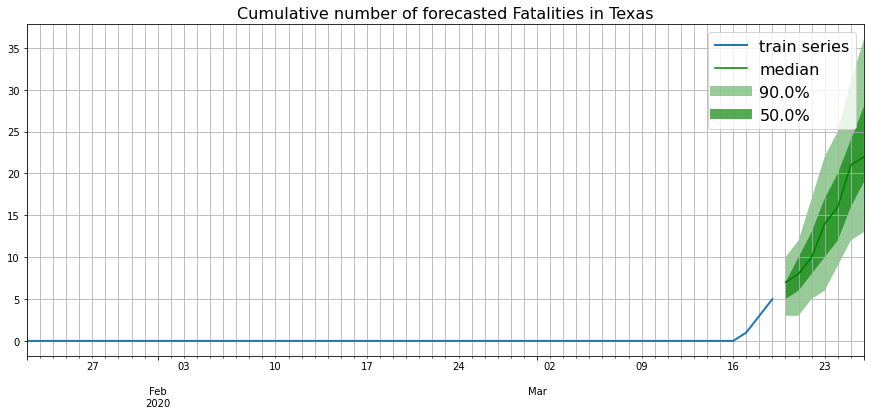

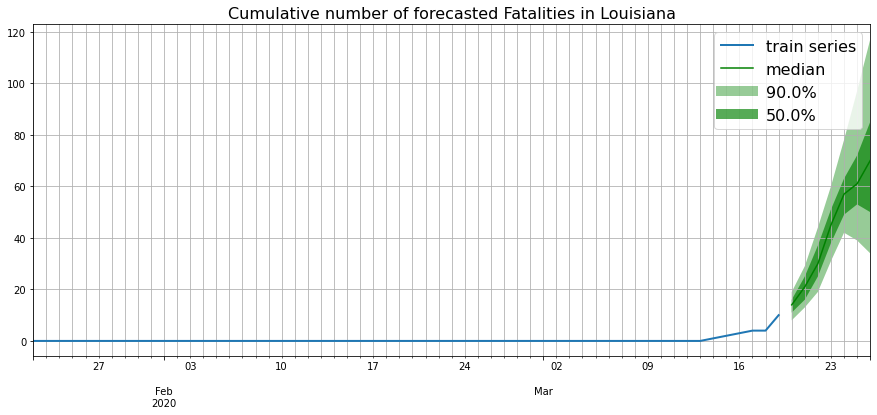

In [26]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt
from typing import List

def plot_forecast(
    predictor,
    location: str = 'New York',
    target: str = 'Fatalities',
    cat_vars: str = 'Province/State',
    real_vars: typing.List[str] = REAL_VARS,
    log_preds: bool = False,
    fontsize: int = 16
):
    fig = plt.figure(figsize=(15, 6.1), facecolor="white",  edgecolor='k')

    # plot train observations, true observations from public test set, and forecasts
    location_tr = enc.transform(np.array(location).reshape(1,-1))[0]
    tr_df = train_df[train_df['Province/State'].values == location_tr]
    train_obs = ListDataset(
        [{
            FieldName.START: tr_df.index[0], 
            FieldName.TARGET: tr_df[target].values,
            FieldName.FEAT_STATIC_CAT: tr_df[cat_vars].values[0].reshape(1,),
            FieldName.FEAT_STATIC_REAL: tr_df[real_vars].values[0]
        }],
        freq = "D",
    )
    te_df = test_df[test_df['Province/State'].values == location_tr]
    test_gt = ListDataset(
        [{"start": te_df.index[0], "target": te_df[target].values}],
        freq = "D",
    )
    for train_series, gt, forecast in zip(train_obs, test_gt, predictor.predict(train_obs)):
        
        train_series = to_pandas(train_series)
        #gt = to_pandas(gt)
        
        if log_preds:
            train_series = np.expm1(train_series)
            gt = np.expm1(gt)
            forecast.samples = np.expm1(forecast.samples)
        
        train_series.plot(linewidth=2, label = 'train series')
        #gt.plot(linewidth=2, label = 'test ground truth')
        forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
        
    plt.title(f'Cumulative number of forecasted {target} in {location}', fontsize=fontsize)
    plt.legend(fontsize = fontsize)
    plt.grid(which='both')
    plt.show()
    
plot_forecast(predictor_fatalities_all[0], 'New York')
plot_forecast(predictor_fatalities_all[0], 'California')
plot_forecast(predictor_fatalities_all[0], 'Washington')
plot_forecast(predictor_fatalities_all[0], 'Texas')
plot_forecast(predictor_fatalities_all[0], 'Louisiana')


# Calculate metrics on public test

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
import json

all_data = build_dataset(all_df)

# evaluate fatalities predictor
forecast_iterable, ts_iterable = make_evaluation_predictions(
    dataset=all_data,
    predictor=predictor_fatalities,
    num_samples=100
)
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(ts_iterable, forecast_iterable, num_series=len(all_data))
print('Unaugmented Model Fatalities Predictor Metrics: ')
print(json.dumps(agg_metrics, indent=4))

# evaluate confirmed cases predictor
forecast_iterable, ts_iterable = make_evaluation_predictions(
    dataset=all_data,
    predictor=predictor_fatalities_aug,
    num_samples=100
)
agg_metrics, item_metrics = evaluator(ts_iterable, forecast_iterable, num_series=len(all_data))
print('Augmented Model Fatalities Predictor Metrics: ')
print(json.dumps(agg_metrics, indent=4))

# Interrogate importance of covariates 


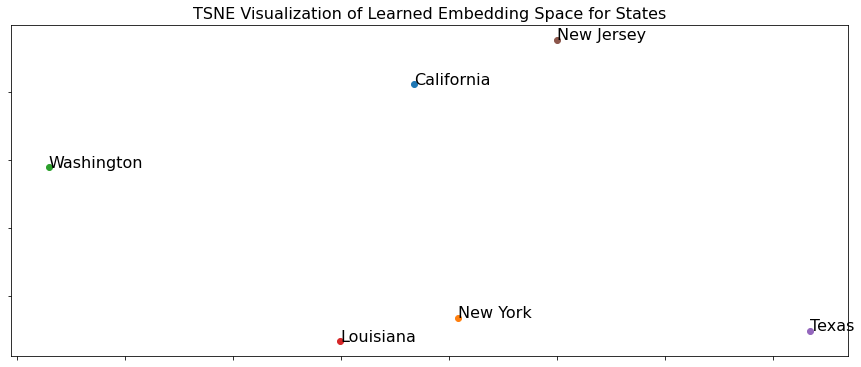

In [18]:
from sklearn import manifold
from matplotlib.ticker import NullFormatter
import typing

# get list of countries with most fatalities
def visualize_embedding(
    trained_net,
    states: typing.List[str] = None
):

    # visualize 2-D projection of learned State embedding space with TSNE
    embedding = trained_net.collect_params()[f'{trained_net.name}_featureembedder0_cat_0_embedding_weight'].data()
    proj = manifold.TSNE(init='pca', random_state = 0).fit_transform(embedding.asnumpy())

    # plot
    fig = plt.figure(figsize=(15, 6.1), facecolor="white",  edgecolor='k')
    ax = plt.gca()

    if states is None:
        states = enc.categories_[0]
    for state in states:
        idx = np.where(enc.categories_[0] == state)[0][0]
        plt.scatter(
            proj[idx, 0], 
            proj[idx, 1], 
            cmap=plt.cm.Spectral, 
        )
        ax.annotate(
            state, 
            (proj[idx, 0], proj[idx, 1]), 
            fontsize=16,
        )
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.title(f"TSNE Visualization of Learned Embedding Space for States", fontsize=16)
    plt.show()

visualize_embedding(net, states = ['California', 'New York', 'Washington', 'Louisiana', 'Texas', 'New Jersey'])